In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
monet_images=[]
photos=[]
for i in os.listdir('/kaggle/input/gan-getting-started/monet_jpg'):
    monet_images.append(os.path.join('/kaggle/input/gan-getting-started/monet_jpg',i))
for i in os.listdir('/kaggle/input/gan-getting-started/photo_jpg'):
    photos.append(os.path.join('/kaggle/input/gan-getting-started/photo_jpg',i))
def imgtoarr(path):
    image = tf.image.decode_jpeg(path, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256,256, 3])
    return image
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset
monet_arr=map(imgtoarr,monet_images)
photos_arr=map(imgtoarr,photos)
def generator_model():
    model =tf.keras.Sequential()
#     model.add(layers.Input(shape=(100,)))
    model.add(layers.Dense(7*7*256,input_shape=(100,)))
#     model.add(layers.Conv2DTranspose(128,5,padding='same',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape(target_shape=(7,7,256)))
    
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128,5,padding='same',strides=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128,5,padding='same',strides=(3,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128,4,padding='same',strides=(3,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128,4,padding='same',strides=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128,4,padding='same',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(1,4,padding='same',activation='sigmoid'))
    return model

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
generator=generator_model()
generated_image=generator(tf.convert_to_tensor(tf.random.normal([1,100])),training=False)

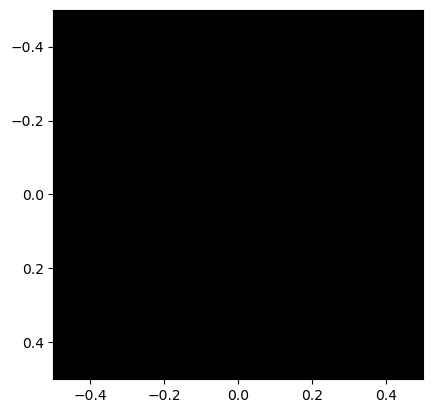

In [3]:
import matplotlib.pyplot as plt
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [4]:
from tensorflow.keras.models import Model
def discrimatior_model():
    model =tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[7,7,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [5]:
discrimator=discrimatior_model()
# print(discrimator(generated_image))

In [6]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real,fake):
    real_loss=cross_entropy(tf.ones_like(real),real)
    fake_loss=cross_entropy(tf.zeros_like(fake),fake)
    loss=real_loss+fake_loss
    return loss
def generator_loss(fake):
    return cross_entropy(tf.zeros_like(fake),fake)
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [7]:
@tf.function
def train_image(image):
    noise=tf.random.normal([1,100])
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_image=generator(noise,training=True)
        
        real_output=discriminator(image,training=True)
        fake_output=discriminator(generated_image,training=True)
        
        gen_loss=generator_loss(fake_output)
        disc_loss=discriminator_loss(real_output,fake_output)
    gradients_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_discriminator=disc_tape.gradient(gen_loss,discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_discriminator,discriminator.trainable_variables))